In [371]:
from os import path
import pandas as pd
import seaborn as sns; sns.set()
import numpy as np
from abacat import SequenceFile
from matplotlib import pyplot as plt
from scipy.stats import linregress
from matplotlib.patches import Patch, Ellipse
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
plt.style.use('seaborn-dark-palette')

In [372]:
# Importing data
df = pd.read_csv("../data/metadata.csv")
df = df[~df['checkm_completeness'].isna()]
df = df[df['quality_filter']]

# Format columns
def fill_rank(row, rank='genus'):
    ranks = {
        "genus": 0,
        "species": 1,
        "strain": 2
    }
    label = ""
    if row['is_synecho']:
        if ranks[rank] < 2:
            label = str(row['label'].split("_")[ranks[rank]])
        if len(label) > 1:
            pass
        else:
            label = str(row[f'gtdb_{rank}'])
    else:
        label += str(row[f'gtdb_{rank}'])
    return label

# Formatting columns
df["gc"] = df["gc"] * 100
df['new_genus'] = df.apply(lambda row: 'Other cyanobacteria' if row['is_synecho'] == False else row['new_genus'], axis=1)

In [373]:
def main(data, figsize=(15,15), axis_lim=((1,7), (30,70)), **kwargs):
    fig = plt.figure(figsize=figsize)
    
    gs = GridSpec(
    nrows=3, ncols=2, height_ratios=[1,1,1], wspace=0.05
    )
    
    markers = ['o', 'v', '^', '<', 'p', '>',] * 5 # 's', 'D', 'd', 'P', 'X'] * 5
    
    ax0 = fig.add_subplot()
    if axis_lim:
        ax0.set_xlim(axis_lim[0])
        ax0.set_ylim(axis_lim[1])
        
    data = data.rename(columns={'new_genus': "Genus"})
    data["no_genus"] = data["no_genus"].astype(str)
    data["Genus"] = data.apply(lambda row: row["Genus"] + f" ({row['no_genus']})", axis=1)
    
    sns.scatterplot(x='megabases', y='gc', data=data, alpha=0.8,
                    hue=data["Genus"], style=data["Genus"],
                    s=100, ax=ax0, zorder=1, markers=markers)
    
    if 'data_' in kwargs.keys():
        sns.scatterplot(x='megabases', y='gc', data=kwargs['data_'],
                        color='lightgray', alpha=0.6, s=100, ax=ax0, zorder=0)
        
    if 'save' in kwargs.keys():
        plt.savefig(kwargs['save'], dpi=600)
    
    plt.show()

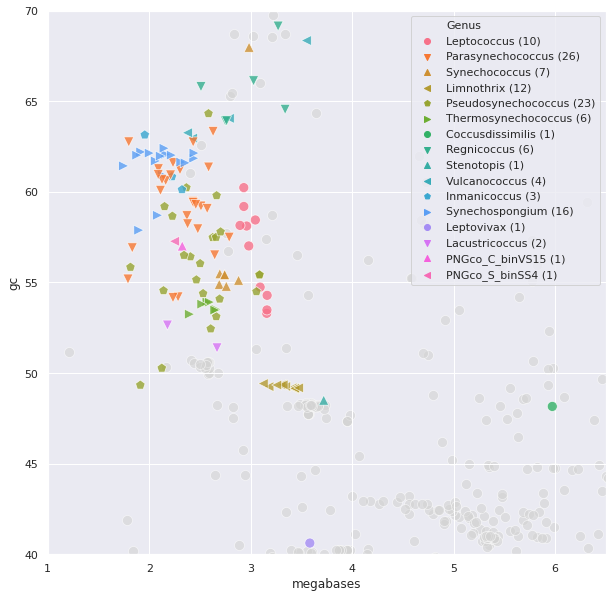

In [374]:
# Our draft
df_ = df[df['quality_filter'] & (df['checkm_completeness'] > 85)].copy()

df_['no_genus'] = df_.groupby('new_genus')[
    'new_genus'].transform('count').map(int, na_action="ignore")

data = df_[(df_['is_synecho']) &
           ~(df_['new_genus'].isin(("GCA", "PCC-7336"))) &
           (df_['no_genus'] > 0)].copy()
data_ = df_[~df_['is_synecho']].copy()

models = []

for dataframe in (data, data_):
    model = linregress(dataframe['checkm_completeness'], dataframe['megabases'])
    models.append(model)
    dataframe['megabases'] = dataframe.apply(lambda row: model.intercept +
                                   model.slope * row['checkm_completeness'] if
                                   row['checkm_completeness'] < 95 else row['megabases'], axis=1)

main(data=data, data_=data_, figsize=(10,10), axis_lim=((1,6.5), (40, 70)),
     save="../data/plots/gc_size/gc_size_adjusted.png")

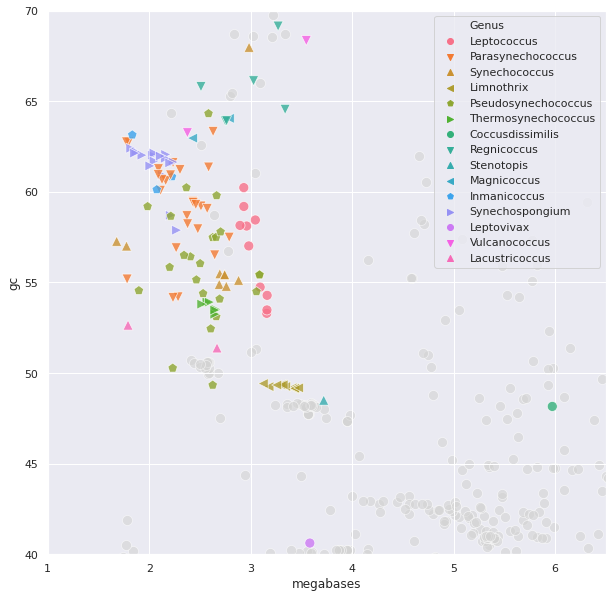

In [340]:
# Without adjusting genome size to completeness
df_ = df[df['quality_filter'] & (df['checkm_completeness'] > 85)].copy()

df_['no_genus'] = df_.groupby('new_genus')[
    'new_genus'].transform('count').map(int, na_action="ignore")

data = df_[(df_['is_synecho']) &
           ~(df_['new_genus'].isin(("GCA", "PCC-7336"))) &
           (df_['no_genus'] > 0)]


data_ = df_[~df_['is_synecho']]

main(data=data, data_=data_, figsize=(10,10), axis_lim=((1,6.5), (40, 70)))

### Calculate regression to fit genome size to genome completeness

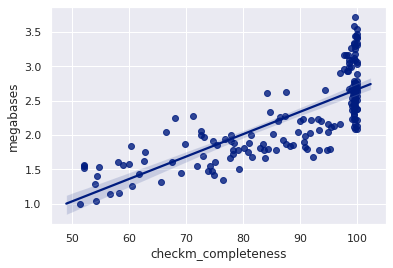

In [316]:
sns.regplot(x='checkm_completeness', y='megabases', data=df[(df['quality_filter']) & (df['is_synecho']) & (df['megabases'] < 4)])

In [325]:
df_ = df[(df['quality_filter']) & (df['is_synecho']) & (df['checkm_completeness'] > 95)]
model = linregress(df_['checkm_completeness'], df_['megabases'])
df_['checkm_completeness'] * model.slope + model.intercept